# 0. Install and Import Dependencies

In [ ]:
!pip list

In [4]:
!pip install opencv-python==4.6.0.66 matplotlib==3.6.2 imageio==2.23.0 gdown==4.6.0 tensorflow==2.10.1 numpy==1.24.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 112.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 64.4 MB/s eta 0:00:00
  Attempting uninstall: keras
  

In [13]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [14]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [16]:
import gdown

In [17]:
# https://drive.google.com/file/d/1Eo3KRafygvcldP2m6O-Ww2fg_f0lxiwJ/view?usp=sharing
url = 'https://drive.google.com/uc?id=1Eo3KRafygvcldP2m6O-Ww2fg_f0lxiwJ'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1Eo3KRafygvcldP2m6O-Ww2fg_f0lxiwJ
To: /content/data.zip
100%|██████████| 434M/434M [00:04<00:00, 91.1MB/s]


['data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/alignments/s

In [18]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [19]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [20]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [21]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [22]:
num_to_char([2,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'b', b'i', b'c', b'k'], dtype=object)>

In [23]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [24]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [25]:
test_path = './/data//s1//bbal6n.mpg'

In [26]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('//')[-1].split('.')[0]

'bbal6n'

In [27]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

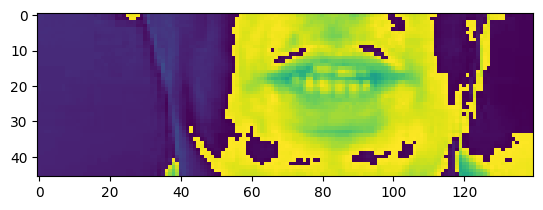

In [28]:
plt.imshow(frames[40])

In [29]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [30]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [31]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [32]:
from matplotlib import pyplot as plt

In [33]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

50

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next();
val[0]

array([[[[[1.2668508 ],
          [1.2668508 ],
          [1.2668508 ],
          ...,
          [0.10858721],
          [0.10858721],
          [0.10858721]],

         [[1.2668508 ],
          [1.2668508 ],
          [1.2668508 ],
          ...,
          [0.10858721],
          [0.10858721],
          [0.10858721]],

         [[1.2306551 ],
          [1.2306551 ],
          [1.2306551 ],
          ...,
          [0.03619574],
          [0.14478296],
          [0.14478296]],

         ...,

         [[0.8686977 ],
          [0.8686977 ],
          [0.8686977 ],
          ...,
          [7.5649095 ],
          [8.361216  ],
          [9.121326  ]],

         [[0.8686977 ],
          [0.8686977 ],
          [0.8686977 ],
          ...,
          [7.2391477 ],
          [7.926867  ],
          [8.759369  ]],

         [[0.8686977 ],
          [0.8686977 ],
          [0.8686977 ],
          ...,
          [7.021973  ],
          [7.7096925 ],
          [8.433607  ]]],


        [[[1.1944

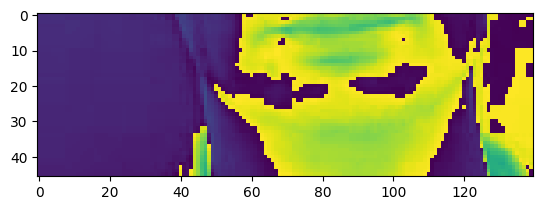

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][60])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green with u seven soon'>

# 3. Design the Deep Neural Network

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [ ]:
5*17*75

6375

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 7s 7s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'xxxxxyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy'>

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'xxxxxyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [41]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [42]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [43]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, epochs=10, callbacks=[checkpoint_callback, schedule_callback])

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')
# model_save_name = 'lipnet10.h5'
# path = F"/content/gdrive/My Drive/{model_save_name}"
# model.save(path)

Mounted at /content/gdrive


  ### Retraining

In [ ]:
model.fit(train, epochs=10, callbacks=[checkpoint_callback, schedule_callback])

Epoch 1/10
450/450 [==============================] - 485s 1s/step - loss: 87.2006 - lr: 1.0000e-04
Epoch 2/10
450/450 [==============================] - 481s 1s/step - loss: 71.4220 - lr: 1.0000e-04
Epoch 3/10
450/450 [==============================] - 481s 1s/step - loss: 67.1706 - lr: 1.0000e-04
Epoch 4/10
450/450 [==============================] - 480s 1s/step - loss: 63.9497 - lr: 1.0000e-04
Epoch 5/10
450/450 [==============================] - 488s 1s/step - loss: 61.8021 - lr: 1.0000e-04
Epoch 6/10
450/450 [==============================] - 480s 1s/step - loss: 59.8748 - lr: 1.0000e-04
Epoch 7/10
450/450 [==============================] - 482s 1s/step - loss: 57.6313 - lr: 1.0000e-04
Epoch 8/10
450/450 [==============================] - 480s 1s/step - loss: 55.6348 - lr: 1.0000e-04
Epoch 9/10
450/450 [==============================] - 484s 1s/step - loss: 53.6212 - lr: 1.0000e-04
Epoch 10/10
450/450 [==============================] - 475s 1s/step - loss: 50.1333 - lr: 1.0000e-04

In [ ]:
model_save_name = 'model10.h5'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.save(path)

In [ ]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/model10.h5', compile=False)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
model.fit(train, epochs=10, callbacks=[checkpoint_callback, schedule_callback])

In [ ]:
model_save_name = 'model20.h5'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.save(path)

In [ ]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/model20.h5', compile=False)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
model.fit(train, epochs=10, callbacks=[checkpoint_callback, schedule_callback])

In [ ]:
model_save_name = 'model30.h5'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.save(path)

In [ ]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/model30.h5', compile=False)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
model.fit(train, epochs=10, callbacks=[checkpoint_callback, schedule_callback])

In [ ]:
model_save_name = 'model40.h5'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.save(path)

In [ ]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/model40.h5', compile=False)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
model.fit(train, epochs=10, callbacks=[checkpoint_callback, schedule_callback])

In [ ]:
model_save_name = 'model50.h5'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.save(path)

In [ ]:
# Training after 50 Date : 29 Oct 2023
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/model50.h5', compile=False)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)


In [ ]:
model.fit(train, epochs=10, callbacks=[checkpoint_callback, schedule_callback])

In [ ]:
model_save_name = 'model60.h5'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.save(path)

# 5. Make a Prediction

In [44]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/model60.h5', compile=False)
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
# sample is a tuple of 2 rows, each row containing - frames, alignment
print(sample[0].shape)
print(sample[1].shape)
print(sample[1])


(2, 75, 46, 140, 1)
(2, 40)
[[16 12  1  3  5 39  7 18  5  5 14 39  1 20 39  1 39  5  9  7  8 20 39 16
  12  5  1 19  5  0  0  0  0  0  0  0  0  0  0  0]
 [19  5 20 39 18  5  4 39  1 20 39  5 39  6 15 21 18 39 16 12  5  1 19  5
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [ ]:
for x in range(5):
  sample = test_data.next()
  yhat = model.predict(sample[0])

  print('~'*100, 'REAL TEXT')
  [print(tf.strings.reduce_join([num_to_char(word) for word in sentence])) for sentence in sample[1]]

  decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
  print('~'*100, 'PREDICTIONS')
  [print(tf.strings.reduce_join([num_to_char(word) for word in sentence])) for sentence in decoded]

1/1 [==============================] - 3s 3s/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
tf.Tensor(b'lay blue sp with e six please', shape=(), dtype=string)
tf.Tensor(b'bin blue with m four now', shape=(), dtype=string)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
tf.Tensor(b'lay blue spwith e six please', shape=(), dtype=string)
tf.Tensor(b'bin blue with m four now', shape=(), dtype=string)
1/1 [==============================] - 0s 236ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT
tf.Tensor(b'bin blue in r six now', shape=(), dtype=string)
tf.Tensor(b'bin green with u seven soon', shape=(), dtype=string)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS
tf.Tensor(b'bin blue in r six now', shape=(), dtype=string)
tf

In [ ]:
sample = test_data.next()
yhat = model.predict(sample[0])

print(yhat)

print('~'*100, 'REAL TEXT')
[print(tf.strings.reduce_join([num_to_char(word) for word in sentence])) for sentence in sample[1]]

decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
print('~'*100, 'PREDICTIONS')
[print(tf.strings.reduce_join([num_to_char(word) for word in sentence])) for sentence in decoded]

1/1 [==============================] - 0s 285ms/step
[[[1.71557687e-07 2.19453028e-07 9.99739587e-01 ... 7.07961190e-11
   2.14904485e-05 2.24930318e-07]
  [1.76517023e-08 2.28820310e-04 1.33828435e-05 ... 1.02141494e-12
   4.01806432e-07 1.26118550e-06]
  [1.92947965e-07 1.29964064e-07 1.03290461e-06 ... 8.44103260e-12
   9.40326063e-05 5.72905776e-07]
  ...
  [9.99937057e-01 3.20475579e-09 4.47756108e-08 ... 3.77555938e-11
   2.96634770e-08 6.06141984e-05]
  [2.28327062e-05 3.20272177e-11 2.61474953e-10 ... 5.20313239e-15
   2.49926613e-09 9.99976516e-01]
  [9.99797523e-01 3.25677485e-09 1.47913511e-07 ... 2.36728952e-11
   3.52575512e-07 1.93599451e-04]]

 [[4.89412315e-08 1.98275416e-06 9.11125426e-06 ... 5.23155907e-10
   5.60036995e-07 1.91797778e-08]
  [7.74211806e-09 3.61720158e-05 2.28854333e-06 ... 1.38990945e-11
   3.26141780e-09 3.06346379e-08]
  [9.02559083e-10 9.99913812e-01 6.29152908e-08 ... 2.34237074e-11
   6.03318950e-10 1.04849622e-08]
  ...
  [9.99963760e-01 1.8161

[None, None]

# Test on a Video from our dataset

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))
print(sample[0].shape) # 75 frames
print(sample[1].shape) # alignments
# sample = load_data(tf.convert_to_tensor('./content/id23_6000_priazn.mpg'))

(75, 46, 140, 1)
(23,)


In [ ]:
type(sample[0])

tensorflow.python.framework.ops.EagerTensor

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 970ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

# Predicting on Random Video

In [ ]:
# !ls /content/gdrive/MyDrive

In [ ]:
import dlib
import cv2

In [ ]:
def custom_load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        #frame = tf.image.rgb_to_grayscale(frame) # tf object is not valid with dlib , numpy array needed

        # Convert the image to grayscale for face detection
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #frames.append(frame[190:236,80:220,:])

        # Load the face detection model from Dlib
        face_detector = dlib.get_frontal_face_detector()

        # Load the shape predictor model for facial landmarks
        shape_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

        # detect faces in frame
        faces = face_detector(frame)

        if len(faces) > 0:
          # Assuming there is only one face in the image
          face = faces[0]

          # Get the facial landmarks
          landmarks = shape_predictor(frame, face)

          # Extract the lip region based on landmarks
          lip_x, lip_y = landmarks.part(48).x, landmarks.part(51).y
          lip_width, lip_height = landmarks.part(54).x - lip_x, landmarks.part(57).y - lip_y

          # Define the desired lip size
          desired_lip_width, desired_lip_height = 140, 46

          # Calculate the crop region for the lip while centering it
          x = lip_x - (desired_lip_width - lip_width) // 2
          y = lip_y - (desired_lip_height - lip_height) // 2

          # Crop the lip region
          cropped_lip = frame[y:y+desired_lip_height, x:x+desired_lip_width]

          # Save the cropped lip region
          frames.append(cropped_lip)

    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
# Random video
vid = custom_load_video("bbaf5a.mpg")

In [ ]:
print(vid.shape)

(75, 46, 140)


In [ ]:
vid = tf.expand_dims(vid, axis=-1)
print(vid.shape)


(75, 46, 140, 1)


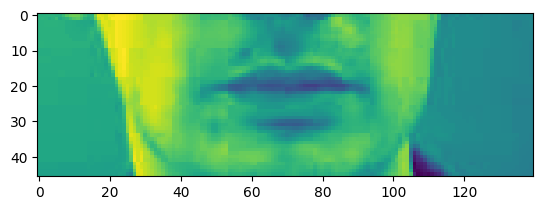

In [ ]:
plt.imshow(vid[0])

In [ ]:
# predicting
yhat = model.predict(tf.expand_dims(vid, axis=0))
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
print('~'*50, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

1/1 [==============================] - 0s 166ms/step
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set brle at sere agoon'>]

### Word Error Rate

In [34]:
import numpy
import doctest

def wer(r, h):
    """
    wer("who is there".split(), "is there".split())
    """
    # initialisation
    d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)]

def wer_sentence(r, h):
    return wer(r.split(), h.split())

In [45]:
test_data = test.as_numpy_iterator()

num=0
dem=0

for x in range(50):
  sample = test_data.next()
  yhat = model.predict(sample[0])
  decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
  real = [(tf.strings.reduce_join([num_to_char(word) for word in sentence])) for sentence in sample[1]]
  predicted = [(tf.strings.reduce_join([num_to_char(word) for word in sentence])) for sentence in decoded]
  num = num + wer(real, predicted)
  dem = dem + len(real)
print('WER: ')
print(num/dem)

1/1 [==============================] - 0s 199ms/step
WER: 
0.16
